# MEDIA (IMAGE & AUDIO) PROCESSING AND VISUALIZATION

## Audio Data Processing & Visualization
In this section, we will load the raw audio samples collected from each team member. Our goal is to visualize each audio file in two ways to understand its properties:

- **Waveform:** To see the amplitude of the audio over time.

- **Spectrogram:** To see the frequency content of the audio over time.



In [9]:
import librosa
import librosa.display
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob

C:\Users\HP\AppData\Local\Temp\ipykernel_18756\1509806541.py:12: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path)
c:\Users\HP\rekomai\tf_env\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Could not process ../data/audio\benitha_approve.aac. Error: 
Could not process ../data/audio\benitha_confirm.aac. Error: 
Could not process ../data/audio\clinton_approve.aac. Error: 
Could not process ../data/audio\clinton_confirm.aac. Error: 
--- Processing: armand_approve.ogg ---


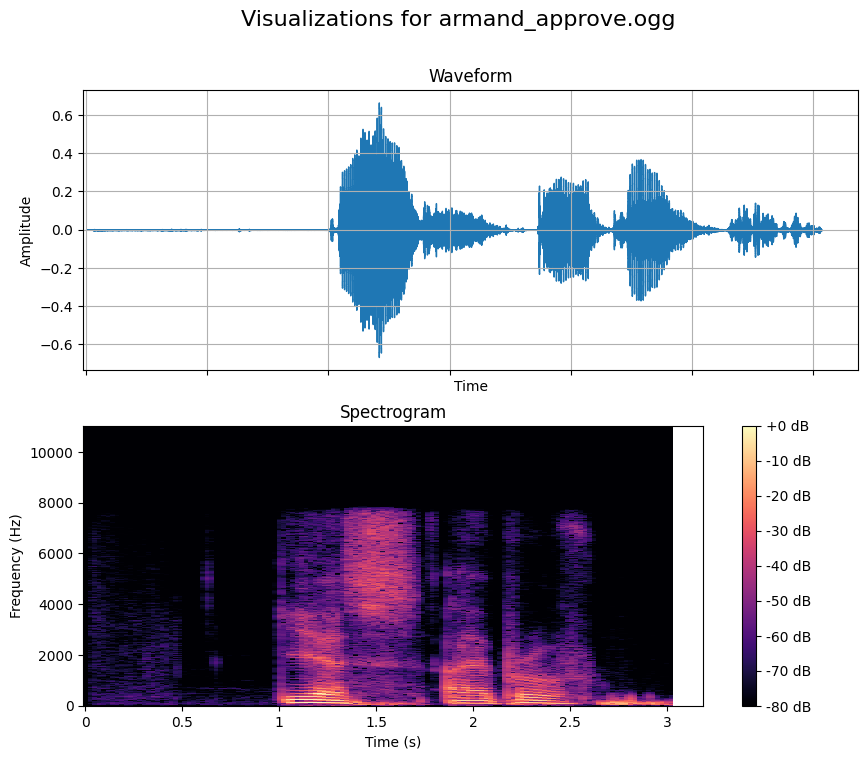

--- Processing: armand_confirm.ogg ---


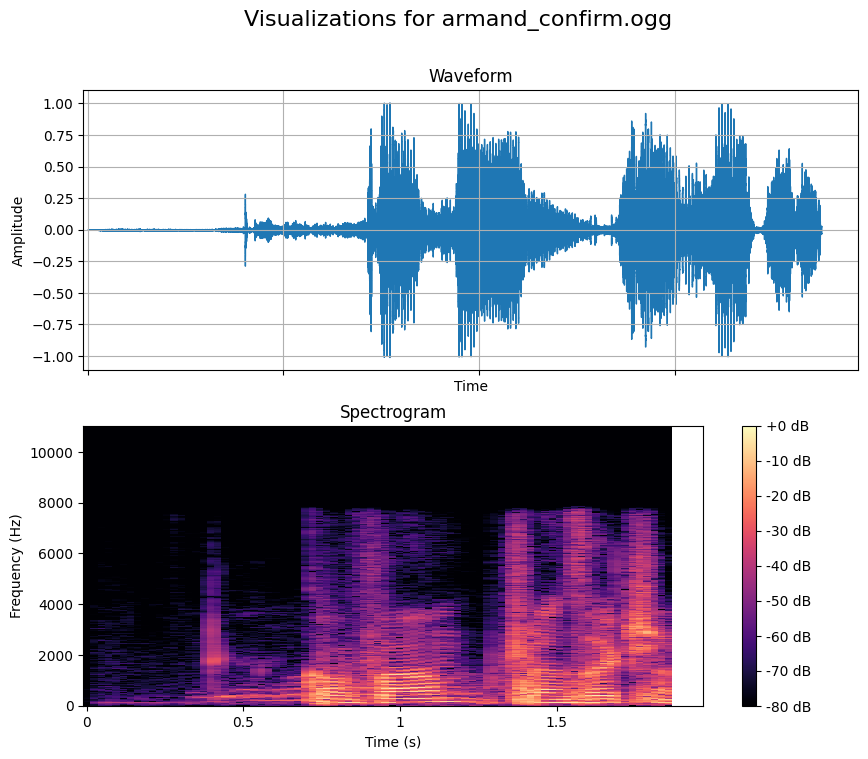

--- Processing: christian_approve.ogg ---


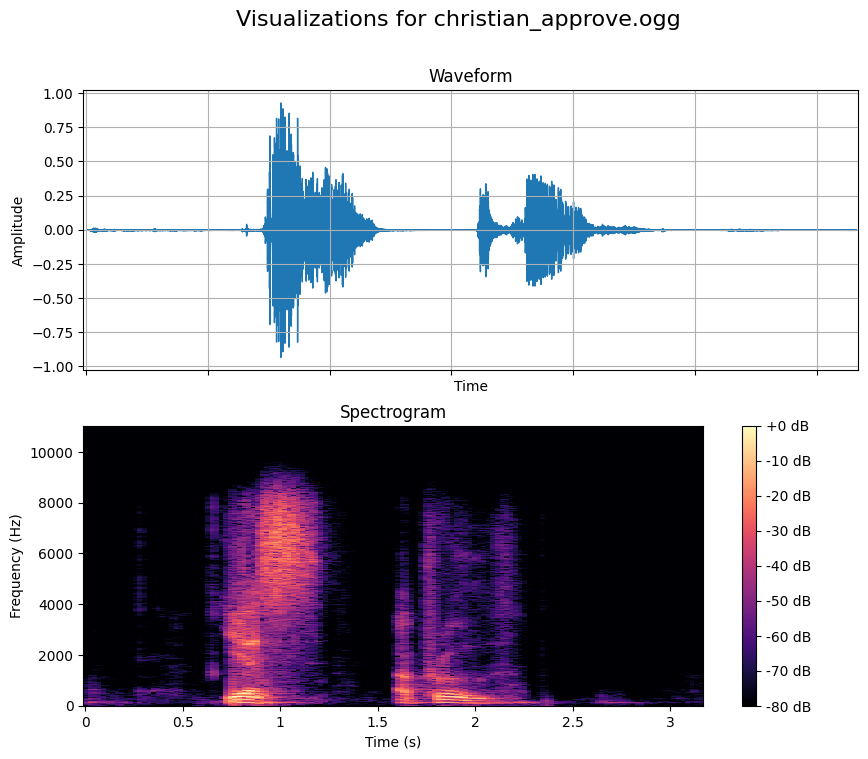

--- Processing: christian_confirm.ogg ---


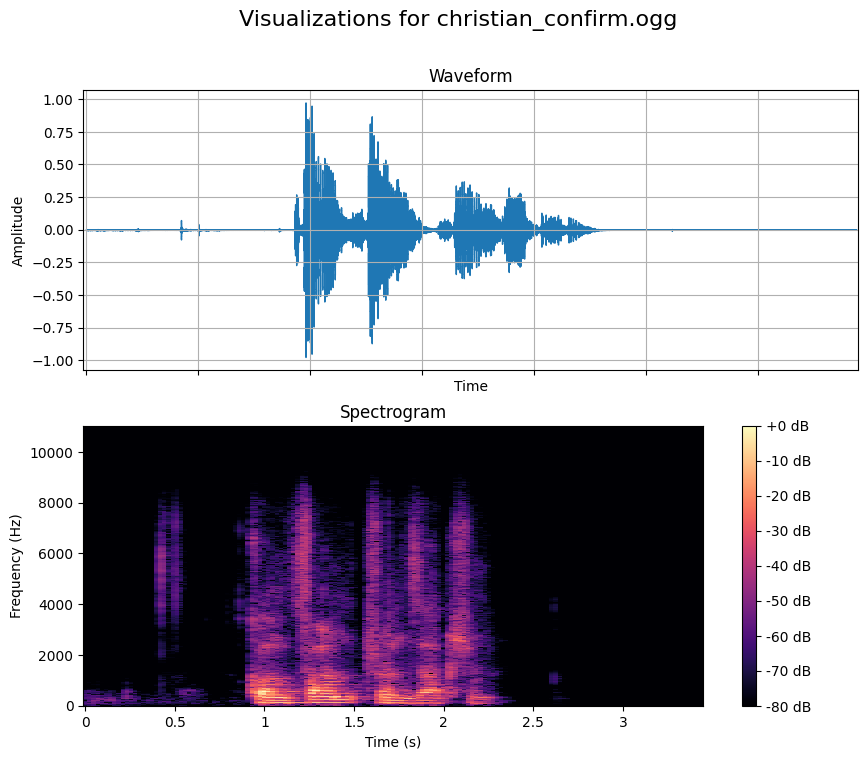

--- Processing: Jeremiah_approve.ogg ---


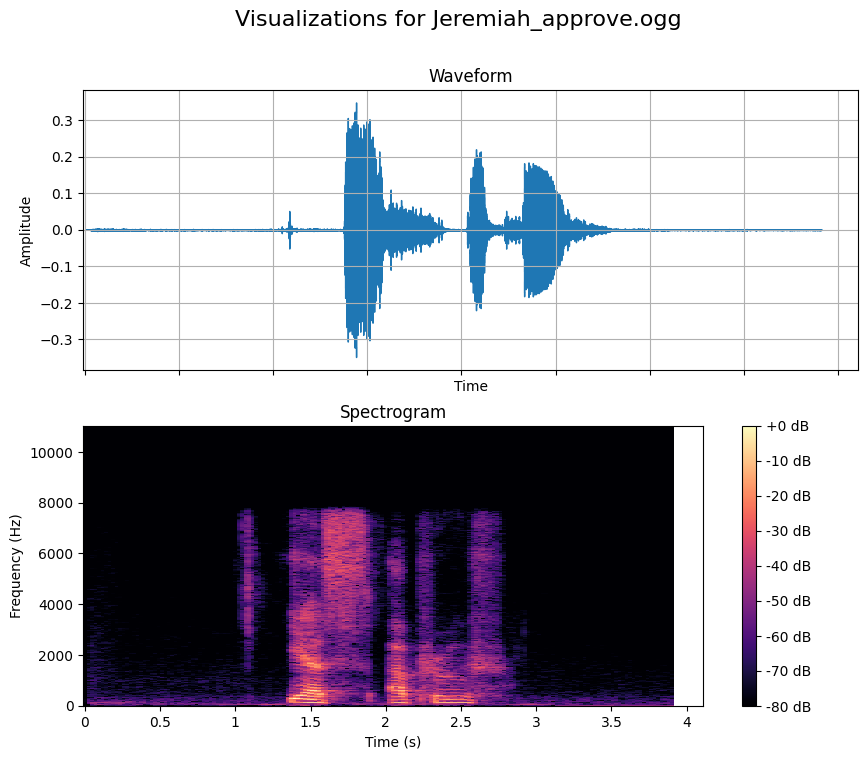

--- Processing: Jeremiah_confirm.ogg ---


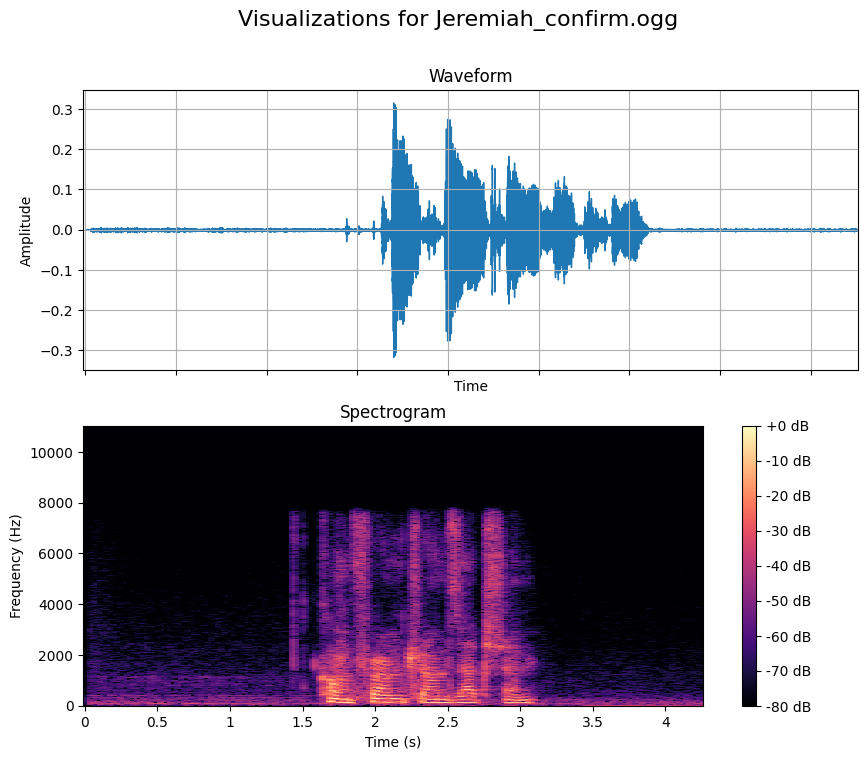

In [ ]:
# Define the path to your audio files
audio_folder = '../data/audio/'
# Create a list of all audio files, regardless of format
audio_files = []
for extension in ['*.wav', '*.aac', '*.ogg', '*.m4a','*.mp3','*.mp4']:
    audio_files.extend(glob.glob(os.path.join(audio_folder, extension)))

# Loop through each found audio file
for file_path in audio_files:
    try:
        # Load the audio file
        y, sr = librosa.load(file_path)
        file_name = os.path.basename(file_path)

        print(f"--- Processing: {file_name} ---")

        # Create a figure for the plots
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(10, 8))
        fig.suptitle(f'Visualizations for {file_name}', fontsize=16)

        # 1. Plot the waveform
        librosa.display.waveshow(y, sr=sr, ax=ax[0])
        ax[0].set_title('Waveform')
        ax[0].set_ylabel('Amplitude')
        ax[0].grid(True)

        # 2. Plot the spectrogram
        D = librosa.stft(y)
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', ax=ax[1])
        ax[1].set_title('Spectrogram')
        ax[1].set_ylabel('Frequency (Hz)')
        ax[1].set_xlabel('Time (s)')
        fig.colorbar(img, ax=ax[1], format='%+2.0f dB')

        plt.show()

    except Exception as e:
        print(f"Could not process {file_path}. Error: {e}")

**Overall Interpretation**

After generating the visualizations for all audio files, we can make several key observations.
- **Data Quality:** The recordings are generally clean, with distinct periods of speech and silence visible in the waveforms. There's a noticeable variation in the recording amplitudes; for example, 
`christian_approve.ogg` and `armand_confirm.ogg` have much higher amplitudes (reaching +/- 1.0) compared to 
`benitha_approve.aac`  (around +/- 0.2). This indicates a need for volume normalization.

- **Consistency:** When comparing the same phrase across different speakers (e.g., "approve"), the waveforms consistently show two main bursts of sound corresponding to the two words "Yes, approve". While the general structure is consistent, the duration and specific shape of the waveforms differ for each person, which is expected.

- **Uniqueness:** The spectrograms clearly highlight the unique vocal characteristics of each speaker. Even when saying the same word, the patterns of the bright, high-energy frequency bands are distinct for each person. For instance, Christian's spectrograms show significant energy in higher frequencies , whereas Jeremiah's energy is more concentrated in the lower-to-mid frequencies. These unique "voiceprints" are exactly what the voice verification model will use to distinguish between individuals.

### Audio Augmentation & Feature Extraction
Now that we've inspected the audio, we'll process it for our model. This involves two steps:

1. **Augmentation:** Creating new training samples by slightly modifying the existing ones. This makes our model more robust.

2. **Feature Extraction:** Converting each audio clip into a single vector of numbers that represents its acoustic qualities.

#### Step 1: Define Augmentation Functions

We will define functions for the two augmentations we'll use: adding noise and shifting the pitch.

In [11]:
def add_noise(y, noise_factor=0.005):
    """Adds random noise to an audio signal."""
    noise = np.random.randn(len(y))
    return y + noise_factor * noise

def shift_pitch(y, sr, n_steps):
    """Shifts the pitch of an audio signal."""
    return librosa.effects.pitch_shift(y=y, sr=sr, n_steps=n_steps)

def time_stretch(y, rate):
    """Stretches the time of an audio signal."""
    return librosa.effects.time_stretch(y=y, rate=rate)

#### Step 2: Define Feature Extraction Function

This function will take an audio signal and compute several types of features, then combine them into a single feature vector. We'll focus on MFCCs as they are powerful for voice recognition.

In [12]:
def extract_features(y, sr):
    """Extracts a feature vector from an audio signal."""
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfccs_mean = np.mean(mfccs.T, axis=0)
    
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = np.mean(rolloff)
    
    features = np.hstack((mfccs_mean, rolloff_mean))
    return features

#### Step 3: Process All Files and Save to CSV

Finally, we'll loop through all our audio files again. For each file, we'll extract features from the original audio and from two augmented versions. All results will be saved in a list and then converted to a DataFrame.

In [13]:
# --- Implementation: Main Processing Loop (Expanded) ---
processed_data = []
audio_folder = '../data/audio/'
audio_files = []
for extension in ['*.wav', '*.aac', '*.ogg']:
    audio_files.extend(glob.glob(os.path.join(audio_folder, extension)))

for file_path in audio_files:
    try:
        y, sr = librosa.load(file_path, sr=None) # Load with original sampling rate
        speaker = os.path.basename(file_path).split('_')[0]

        # 1. Original
        processed_data.append([speaker, *extract_features(y, sr), 'original'])
        
        # --- 8 Augmented Versions ---
        # 2. Add Noise
        y_noisy = add_noise(y)
        processed_data.append([speaker, *extract_features(y_noisy, sr), 'noise'])
        
        # 3. Pitch Shift Up
        y_pitch_up = shift_pitch(y, sr, n_steps=2)
        processed_data.append([speaker, *extract_features(y_pitch_up, sr), 'pitch_up'])

        # 4. Pitch Shift Down
        y_pitch_down = shift_pitch(y, sr, n_steps=-2)
        processed_data.append([speaker, *extract_features(y_pitch_down, sr), 'pitch_down'])
        
        # 5. Time Stretch Slower
        y_stretch_slow = time_stretch(y, rate=0.8)
        processed_data.append([speaker, *extract_features(y_stretch_slow, sr), 'stretch_slow'])

        # 6. Time Stretch Faster
        y_stretch_fast = time_stretch(y, rate=1.2)
        processed_data.append([speaker, *extract_features(y_stretch_fast, sr), 'stretch_fast'])

        # 7. Pitch Shift + Noise
        y_pitch_noise = add_noise(y_pitch_up)
        processed_data.append([speaker, *extract_features(y_pitch_noise, sr), 'pitch_noise'])

        # 8. Time Stretch + Noise
        y_stretch_noise = add_noise(y_stretch_slow)
        processed_data.append([speaker, *extract_features(y_stretch_noise, sr), 'stretch_noise'])

        # 9. Time Shift (Roll)
        y_roll = np.roll(y, shift=int(sr/10)) # Shift by 100ms
        processed_data.append([speaker, *extract_features(y_roll, sr), 'time_shift'])
        
    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Create and save the DataFrame
num_mfccs = 13
columns = ['speaker'] + [f'mfcc_{i+1}' for i in range(num_mfccs)] + ['spectral_rolloff', 'augmentation_type']
audio_features_df = pd.DataFrame(processed_data, columns=columns)

output_path = '../data/outputs/audio_features.csv'
audio_features_df.to_csv(output_path, index=False)

print(f"\nSuccessfully processed {len(audio_files)} original files.")
print(f"DataFrame created with {len(audio_features_df)} total samples.")
print(f"Saved features to {output_path}")

audio_features_df.head(10)

C:\Users\HP\AppData\Local\Temp\ipykernel_18756\271440595.py:10: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=None) # Load with original sampling rate


Error processing ../data/audio\benitha_approve.aac: 
Error processing ../data/audio\benitha_confirm.aac: 
Error processing ../data/audio\clinton_approve.aac: 
Error processing ../data/audio\clinton_confirm.aac: 

Successfully processed 10 original files.
DataFrame created with 54 total samples.
Saved features to ../data/outputs/audio_features.csv


,speaker,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,mfcc_8,mfcc_9,mfcc_10,mfcc_11,mfcc_12,mfcc_13,spectral_rolloff,augmentation_type
0,armand,-376.155792,87.191368,19.626446,20.843725,16.511726,7.067379,-3.743135,1.296438,4.327121,0.357781,-2.678108,-0.862015,1.375042,3329.029605,original
1,armand,-239.939222,38.431715,18.662683,11.382906,9.720907,5.704075,-1.071535,2.494948,2.748917,-0.163694,-1.895652,0.314293,1.810052,5340.707237,noise
2,armand,-398.815491,90.269981,16.760853,23.006599,12.068981,1.914165,-6.222314,5.192492,-0.585451,-2.613006,-3.571637,2.003185,-2.700437,3298.766447,pitch_up
3,armand,-404.377258,95.259018,13.584524,27.179142,11.007110,18.631315,-7.517186,4.091131,-1.807407,8.042714,-6.225858,2.165290,-4.381392,2924.671053,pitch_down
4,armand,-399.941681,86.089035,19.772982,20.814293,16.306522,6.707460,-3.757723,1.205804,4.033646,-0.409862,-2.929890,-1.692217,0.797063,3325.761555,stretch_slow
5,armand,-393.572693,88.540604,20.254932,21.300760,16.072985,6.171988,-3.950294,1.126736,4.909262,-0.619905,-2.844472,-0.947941,1.068761,3302.709652,stretch_fast
6,armand,-247.563763,36.721529,17.712393,9.656837,7.684104,2.032058,-1.592214,1.916304,-0.375138,-1.252597,-1.573820,0.819402,-1.030079,5609.128289,pitch_noise
7,armand,-249.005383,34.877788,18.391078,10.915716,9.046972,4.834543,-1.124684,1.342848,2.345835,-0.234117,-1.819404,-0.981695,1.306587,5620.404412,stretch_noise
8,armand,-369.055664,88.007614,18.689747,20.233845,16.290739,7.115304,-3.556809,1.747237,4.657729,0.596806,-2.443032,-0.760879,1.406817,3356.167763,time_shift
9,armand,-193.040863,123.563889,-14.269038,15.544649,-4.615801,-2.446244,-2.367111,-11.033311,-3.886512,-2.396882,-5.167012,0.540002,-7.798740,2563.426907,original


## Part 2: Image Processing & Feature Extraction

In this section, we will process the raw facial images. The process involves:
- **Augmenting** each image to create additional training data. 
- **Extracting a numerical feature vector** (a color histogram) from each image. 
- **Saving these features** and their corresponding labels to a CSV file.

### Step 1: Visualize a Sample Image
Before we process all the images, we'll load and display one to verify it loads correctly.

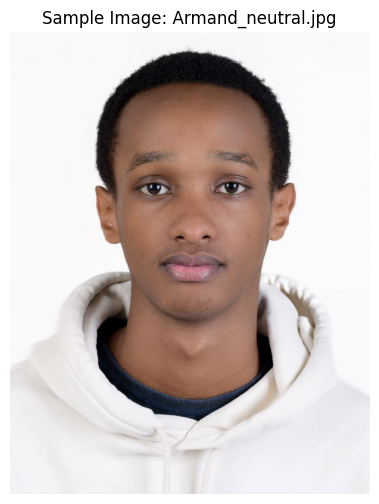

In [14]:
# Load a sample image
sample_image_path = '../data/images/Armand_neutral.jpg'
image = cv2.imread(sample_image_path)

# Convert from BGR to RGB for correct color display
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(image_rgb)
plt.title(f'Sample Image: {os.path.basename(sample_image_path)}')
plt.axis('off') # Hide the axes
plt.show()

### Step 2: Define Feature Extraction & Augmentation Functions
We'll start by creating functions to handle our image operations. A color histogram is a great feature that represents the distribution of colors in an image.

In [15]:
def extract_histogram(image, bins=(8, 8, 8)):
    """Computes a 3D color histogram from an image."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins, [0, 180, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    return hist.flatten()

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h))

def flip_image(image, direction=1): # 1 for horizontal, 0 for vertical
    return cv2.flip(image, direction)

def change_brightness(image, value=30):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, value)
    v[v > 255] = 255
    v[v < 0] = 0
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

def add_gaussian_blur(image):
    return cv2.GaussianBlur(image, (5, 5), 0)

def add_noise(image):
    row, col, ch = image.shape
    mean = 0
    var = 0.1
    sigma = var**0.5
    gauss = np.random.normal(mean, sigma, (row, col, ch))
    gauss = gauss.reshape(row, col, ch)
    noisy = image + image * gauss
    return noisy.astype('uint8')

### Step 3: Process All Images and Save to CSV
Now we will loop through all the `.jpg` files in the `data/images/` folder, extract features from the original and two augmented versions, and save all the data to a DataFrame.

In [16]:
image_folder = '../data/images/'
image_files = glob.glob(os.path.join(image_folder, '*.jpg'))
processed_image_data = []

for file_path in image_files:
    try:
        person_name = os.path.basename(file_path).split('_')[0]
        original_image = cv2.imread(file_path)

        # A list of augmentations to apply
        augmentations = {
            'original': original_image,
            'rotated_pos_10': rotate_image(original_image, 10),
            'rotated_neg_10': rotate_image(original_image, -10),
            'flipped_horizontal': flip_image(original_image, 1),
            'brightness_up': change_brightness(original_image, 50),
            'brightness_down': change_brightness(original_image, -50),
            'blur': add_gaussian_blur(original_image),
            'noise': add_noise(original_image),
            # --- Combinations ---
            'flipped_rotated': rotate_image(flip_image(original_image, 1), 10),
            'flipped_bright': change_brightness(flip_image(original_image, 1), 50),
            'flipped_dark': change_brightness(flip_image(original_image, 1), -50),
            'rotated_bright': change_brightness(rotate_image(original_image, 10), 30),
            'rotated_dark': change_brightness(rotate_image(original_image, -10), -30),
            'blur_bright': change_brightness(add_gaussian_blur(original_image), 30),
            'noise_dark': change_brightness(add_noise(original_image), -30),
        }

        # Loop through the dictionary and process each image version
        for aug_type, aug_image in augmentations.items():
            hist_features = extract_histogram(aug_image)
            processed_image_data.append([person_name, *hist_features, aug_type])

    except Exception as e:
        print(f"Error processing {file_path}: {e}")

# Create and save the DataFrame
hist_size = 8 * 8 * 8 
columns = ['person'] + [f'hist_{i}' for i in range(hist_size)] + ['augmentation_type']
image_features_df = pd.DataFrame(processed_image_data, columns=columns)

output_path = '../data/outputs/image_features.csv'
image_features_df.to_csv(output_path, index=False)

print(f"\nSuccessfully processed {len(image_files)} original images.")
print(f"DataFrame created with {len(image_features_df)} total samples.")
print(f"Saved features to {output_path}")

# Display the first few rows and the shape
print(f"\nShape of the new DataFrame: {image_features_df.shape}")
image_features_df.head()


Successfully processed 15 original images.
DataFrame created with 225 total samples.
Saved features to ../data/outputs/image_features.csv

Shape of the new DataFrame: (225, 514)


,person,hist_0,hist_1,hist_2,hist_3,hist_4,hist_5,hist_6,hist_7,hist_8,...,hist_503,hist_504,hist_505,hist_506,hist_507,hist_508,hist_509,hist_510,hist_511,augmentation_type
0,Armand,0.006080,0.000873,0.000764,0.001217,0.006416,0.013309,0.039455,0.214984,0.002296,...,0.0,0.000589,0.000003,0.00000,0.0,0.0,0.0,0.0,0.0,original
1,Armand,0.209864,0.001364,0.001206,0.001699,0.007448,0.015250,0.045811,0.237199,0.002894,...,0.0,0.000559,0.000003,0.00000,0.0,0.0,0.0,0.0,0.0,rotated_pos_10
2,Armand,0.208967,0.001485,0.001115,0.001630,0.007437,0.015191,0.045288,0.239731,0.002908,...,0.0,0.000568,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,rotated_neg_10
3,Armand,0.006080,0.000873,0.000764,0.001217,0.006416,0.013309,0.039455,0.214984,0.002296,...,0.0,0.000589,0.000003,0.00000,0.0,0.0,0.0,0.0,0.0,flipped_horizontal
4,Armand,0.000000,0.004990,0.001288,0.000801,0.000747,0.002632,0.008124,0.264813,0.000000,...,0.0,0.000000,0.000558,0.00002,0.0,0.0,0.0,0.0,0.0,brightness_up
